# Домашнее задание 2. Классификация изображений.

#### Выполнила Шеневская Влада

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить любое из двух заданий

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

Необходимо написать функции `train_one_epoch`, `train` и `predict` по шаблонам ниже (во многом повторяют примеры с семинаров).Обратите особое внимание на функцию `predict`: она должна возвращать список лоссов по всем объектам даталоадера, список предсказанных классов для каждого объекта из даталоалера и список настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам. Если вы выполнили оба задания, то берется максимум из двух оценок.

__Бонус__. Вы получаете 5 бонусных баллов если справляетесь с обоими заданиями на 10 баллов (итого 15 баллов). В противном случае выставляется максимальная из двух оценок и ваш бонус равен нулю.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [2]:
import numpy as np
import sys
import torch
import torchvision
import tqdm
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
import glob
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor ### поудалять ненужное
import albumentations as A
from tqdm.auto import tqdm
import numpy as np
import random
# You may add any imports you need

In [3]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed) # зафиксировали random seed (функция скопирована с семинара)

In [4]:
set_random_seed(123)

In [ ]:
! unzip "/content/drive/MyDrive/Colab Notebooks/dataset.zip"

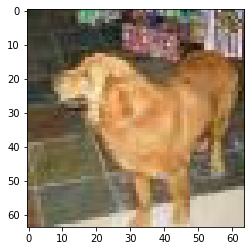

In [9]:
file = np.random.choice(glob.glob("/content/dataset/dataset/train/*/*.jpg"))
plt.imshow(plt.imread(file)); # милый песик

### Подготовка данных

Буду использовать ImageFolder

In [10]:
import torchvision.transforms as T
import PIL

In [26]:
train_transform =  Compose([ 
                            T.ColorJitter(hue=.05, saturation=.05),
                            T.RandomHorizontalFlip(p=0.5),
                            T.RandomRotation(20, resample=PIL.Image.BILINEAR),
                            T.ToTensor(), 
                            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])  #использовала те же аугментации, что и на семинаре                        
val_transform =  Compose([ 
                     T.ToTensor(), 
                     T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #не применяю random аугментации на тесте

train_dataset = ImageFolder("/content/dataset/dataset/train", transform=train_transform)
test_dataset = ImageFolder("/content/dataset/dataset/val", transform=val_transform)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [28]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=200)

In [13]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Вспомогательные функции, реализация модели

In [14]:
# функции взяты с семинара 5 (+убрала не относящиеся к задаче строки, не рассчитываю лоссы, а только accuracy)
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.train().to(device)
    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
      for images, labels in train_dataloader:
        # Move Batch to GPU
        images, labels = images.to(device), labels.to(device)
        pred = model(images)
        loss = criterion(pred, labels)
        # Update weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # Update descirption for tqdm
        accuracy = (pred.argmax(1) == labels).float().mean()
        prbar.set_description(f"Accuracy: {round(accuracy.item() * 100, 3)}") # выводим accuracy
        prbar.update(1)
    pass 


def predict(model, val_dataloder, criterion, device="cuda:0"):
    model.eval().to(device)
    predicted_classes, true_classes, losses = np.array([]), np.array([]), np.array([])
    with tqdm(total=len(val_dataloder), file=sys.stdout) as prbar:
        for images, labels in val_dataloder:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            loss = criterion(pred, labels)
            accuracy = (pred.argmax(1) == labels).float().mean()
            prbar.update(1)
            losses = np.append(losses, loss.item())
            predicted_classes = np.append(predicted_classes, pred.argmax(1).cpu().detach().numpy())
            true_classes = np.append(true_classes, labels.cpu().detach().numpy())  
    return losses, predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    for epoch in range(n_epochs):
      print(f"Train Epoch: {epoch}")
      # обучим нашу модель по эпохам
      train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0")
      # Eval step
      with torch.no_grad():
        losses, predicted_classes, true_classes = predict(model, val_dataloader,criterion, device="cuda:0")     
      print(f'Accuracy per epoch: {accuracy_score(predicted_classes, true_classes)}') 
    pass
  

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(test_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed") 
#он проходит эти тесты! в этой итерации не запустила эту ячейку, а потом у меня закончился GPU поэтому не могу перезапустить(

### Обучение модели, запуски экспериментов

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#scheduler = # LR SCHEDULE THAT YOU PROBABLY CHOOSE
#n_epochs = 5
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

попытка **раз**

In [18]:
#данная функция основана на той, что в семинаре №3
model1 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1), 
    nn.BatchNorm2d(32), 
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1), 
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), 
    nn.Dropout(0.3),

    nn.Conv2d(32, 64, kernel_size=3, padding=1), 
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1), 
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), 
    nn.Dropout(0.3),

    nn.Conv2d(64, 128, kernel_size=3, padding=1), 
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, 3, padding=1), 
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), 
    nn.Dropout(0.3),

    nn.Flatten(), # растягиваем в вектор (перемножим все размеры)
    nn.Linear(128 * 8 * 8, 256), 
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256,200)
)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-3)

In [ ]:
train(model1, train_dataloader, val_dataloader, criterion, optimizer1, device, n_epochs=10, scheduler=None)

Train Epoch: 0


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.1364
Train Epoch: 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.183
Train Epoch: 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.1931
Train Epoch: 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.1977
Train Epoch: 4


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.2372
Train Epoch: 5


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.2448
Train Epoch: 6


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.2854
Train Epoch: 7


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.2679
Train Epoch: 8


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.294
Train Epoch: 9


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.2764


Изменю размер батча, чтобы больше объектов участвовало в обучении, зафиксирую его на уровне 64

In [16]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

попытка **два**

In [ ]:
train(model1, train_dataloader, val_dataloader, criterion, optimizer1, device, n_epochs=10, scheduler=None)

Train Epoch: 0


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy per epoch: 0.2428
Train Epoch: 1


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy per epoch: 0.2743
Train Epoch: 2


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy per epoch: 0.3129
Train Epoch: 3


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy per epoch: 0.287
Train Epoch: 4


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy per epoch: 0.3175
Train Epoch: 5


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy per epoch: 0.3216
Train Epoch: 6


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy per epoch: 0.339
Train Epoch: 7


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy per epoch: 0.3634
Train Epoch: 8


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy per epoch: 0.3453
Train Epoch: 9


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy per epoch: 0.3401


Изменю размер батча до 48

In [17]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=48, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=48)

увеличу количество эпох до 20

попытка **три**

In [21]:
train(model1, train_dataloader, val_dataloader, criterion, optimizer1, device, n_epochs=20, scheduler=None)

Train Epoch: 0


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.1282
Train Epoch: 1


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.1679
Train Epoch: 2


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.2241
Train Epoch: 3


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.2223
Train Epoch: 4


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.2506
Train Epoch: 5


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.2576
Train Epoch: 6


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.2912
Train Epoch: 7


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.2864
Train Epoch: 8


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.31
Train Epoch: 9


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.314
Train Epoch: 10


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.2996
Train Epoch: 11


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.3261
Train Epoch: 12


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.3002
Train Epoch: 13


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.3152
Train Epoch: 14


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.3405
Train Epoch: 15


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.3384
Train Epoch: 16


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.3438
Train Epoch: 17


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.3492
Train Epoch: 18


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.3534
Train Epoch: 19


  0%|          | 0/2084 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Accuracy per epoch: 0.334


не сдаемся и попробуем побольше сверток добавить и убрать dropout

In [29]:
#данная функция основана на той, что в семинаре №3
model5 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1), 
    nn.BatchNorm2d(64), 
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1), 
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), 

    nn.Conv2d(64, 124, kernel_size=3, padding=1),
    nn.BatchNorm2d(124),
    nn.ReLU(),
    nn.Conv2d(124, 124, kernel_size=3, padding=1), 
    nn.BatchNorm2d(124),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), 

    nn.Conv2d(124, 256, kernel_size=3, padding=1), 
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 256, 3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), 

    nn.Flatten(), # растягиваем в вектор (перемножим все размеры)
    nn.Linear(256 * 8 * 8, 256), 
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256,200),
)
criterion5 = nn.CrossEntropyLoss()
optimizer5 = torch.optim.Adam(model5.parameters(), lr=1e-3)

попытка четыре (**финальная**)

In [31]:
train(model5, train_dataloader, val_dataloader, criterion5, optimizer5, device, n_epochs=20, scheduler=None)

Train Epoch: 0


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.1879
Train Epoch: 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.2353
Train Epoch: 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.2359
Train Epoch: 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.3269
Train Epoch: 4


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.3329
Train Epoch: 5


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.3059
Train Epoch: 6


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.3692
Train Epoch: 7


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.3599
Train Epoch: 8


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.3781
Train Epoch: 9


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.361
Train Epoch: 10


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.3801
Train Epoch: 11


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.3501
Train Epoch: 12


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.4049
Train Epoch: 13


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.4167
Train Epoch: 14


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.4192
Train Epoch: 15


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.4314
Train Epoch: 16


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.4177
Train Epoch: 17


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.4393
Train Epoch: 18


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.4132
Train Epoch: 19


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy per epoch: 0.4385


### Проверка полученной accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, реализуйте и запустите функцию `evaluate`. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [32]:
all_losses, predicted_labels, true_labels = predict(model5, val_dataloader, criterion5, device)
assert len(predicted_labels) == len(test_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print(accuracy)
print("Оценка за первое задание составит {} баллов".format(min(10, 10 * accuracy / 0.44)))

  0%|          | 0/50 [00:00<?, ?it/s]

0.4385
Оценка за первое задание составит 9.96590909090909 баллов


### Отчёт об экспериментах 

увеличение качества в основном произошло за счет увеличения количества сверток на выходных каналах (не 128, а 256), что конечно отразилось на том, что последняя модель запускалась 3 часа (на GPU) для получения точности 0.4385

До этого я слишком большой размер батча выбрала, мало эпох ставила, также заметила что если убрать dropout качество лучше становится